# Guided Project: Predicting Employee Productivity Using Tree Models

## Table of contents

## Introduction
We'll be looking at the garment industry and some stats about employees



In [1]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('garments_worker_productivity.csv')

## Data Exploration

The dataset is from a garment manufacturer about worker productivity and is available (https://archive.ics.uci
.edu/dataset/597/productivity+prediction+of+garment+employees). The manufacturer is based in Bangladesh, and workers
were paid in Bangladeshi Taka (**৳** / **BDT**)

### Data Schema



| **Variable Name**       | **Role**       | **Type**          | **Description**                                                                            | **Units** | **Missing Values** |
|-------------------------|----------------|--------------------|--------------------------------------------------------------------------------------------|-----------|---------------------|
| `date`                  | Feature        | Date              | Date in MM-DD-YYYY                                                                         |           | no                  |
| `quarter`               | Feature        | Categorical       | A portion of the month. A month was divided into four quarters                             |           | no                  |
| `department`            | Feature        | Categorical       | Associated department with the instance                                                    |           | no                  |
| `day`                   | Feature        | Categorical       | Day of the Week                                                                            |           | no                  |
| `team_no`               | Feature        | Integer           | Associated team number with the instance                                                   |           | no                  |
| `no_of_workers`         | Feature        | Integer           | Number of workers in each team                                                             |           | no                  |
| `no_of_style_change`    | Feature        | Integer           | Number of changes in the style of a particular product                                     |           | no                  |
| `targeted_productivity` | Feature        | Continuous        | Targeted productivity set by the Authority for each team for each day.                     |           | no                  |
| `smv`                   | Feature        | Continuous        | Standard Minute Value, it is the allocated time for a task                                 |           | no                  |
| `wip`                   | Feature        | Integer           | Work in progress. Includes the number of unfinished items for products                     |           | yes                 |
| `over_time`             | Feature        | Integer           | Represents the amount of overtime by each team in minutes                                  |           | no                  |
| `incentive`             | Feature        | Integer           | Represents the amount of financial incentive (in BDT) that enables or motivates a behavior | BDT       | no                  |
| `idle_time`             | Feature        | Integer           | The amount of time when the production was <br/>interrupted due to several reasons         |           | no                  |
| `idle_men`               | Feature        | Integer           | The number of workers who were idle due to production interruption                         |           | no                  |
| `actual_productivity`     | Target         | Continuous        | The actual % of productivity that was delivered by the workers. It ranges from 0-1.        |           | no                  |

In [8]:
df.head()
df.shape

(1197, 15)

~ 1200 rows and 14 features

### Missing values
The schema indicates there is some missing data for the `wip` feature. Perhaps it was an initiative introduced at
some point during the collection of this data set. Let's check it out

In [5]:
df['wip'].describe()

count      691.000000
mean      1190.465991
std       1837.455001
min          7.000000
25%        774.500000
50%       1039.000000
75%       1252.500000
max      23122.000000
Name: wip, dtype: float64

In [6]:
non_numeric_count = df['wip'].apply(pd.to_numeric, errors='coerce').isnull().sum()
print("Number of non-numeric values:", non_numeric_count)

Number of non-numeric values: 506


It looks about a half of the data set is missing that for this feature. That's too much to exclude

### Data shapes

In [9]:
unique_counts = {col: df[col].nunique() for col in df.columns}
unique_counts

{'date': 59,
 'quarter': 5,
 'department': 3,
 'day': 6,
 'team': 12,
 'targeted_productivity': 9,
 'smv': 70,
 'wip': 548,
 'over_time': 143,
 'incentive': 48,
 'idle_time': 12,
 'idle_men': 10,
 'no_of_style_change': 3,
 'no_of_workers': 61,
 'actual_productivity': 879}

There's 3 `department`s, 12 `team`s, 61 team sizes, interestingly, the `targeted_productivity` and the
`actual_productivity` have about two orders of magnitude difference. Indicating that for a given `target_productivity`
there could be 10 to 100 values for it's `actual_productivity`

In [12]:
{col: df[col].unique() for col in ['team', 'idle_time', 'idle_men', 'no_of_style_change', 'targeted_productivity']}

{'team': array([ 8,  1, 11, 12,  6,  7,  2,  3,  9, 10,  5,  4]),
 'idle_time': array([  0. ,  90. , 150. , 270. , 300. ,   2. ,   5. ,   8. ,   4.5,
          3.5,   4. ,   6.5]),
 'idle_men': array([ 0, 10, 15, 45, 37, 30, 35, 20, 25, 40]),
 'no_of_style_change': array([0, 1, 2]),
 'targeted_productivity': array([0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.35, 0.5 , 0.07, 0.4 ])}

`targeted_productivity` ranges from 0.8 to 0.35, but there appears to be a value of 0.07, which is an odd target
value given the rest are in increments of 5. It could be a data entry problem and the real target was 0.7
`idle_men` indicates that anywhere from 12% to 66% of work force could be waiting for production to start.
`idle_time` currently unsure if this is in minutes, seconds, hours. It's an odd range. We may need to do some
cleaning of this as well


In [13]:
df['idle_time'].value_counts()

idle_time
0.0      1179
3.5         3
2.0         2
8.0         2
4.0         2
4.5         2
5.0         2
90.0        1
270.0       1
150.0       1
300.0       1
6.5         1
Name: count, dtype: int64

Only 18 `idle_time` values that are non-zero, interesting. Probably indicating this feature is not going to be a
great predictor of productivity given the limited data, but it would be unfair to ignore it

In [14]:
df['idle_men'].value_counts()

idle_men
0     1179
10       3
15       3
30       3
20       3
35       2
37       1
45       1
25       1
40       1
Name: count, dtype: int64

There's 18 non-zero values for `idle_men` as well. Let's take a look at those data entries

In [15]:
df[(df['idle_men'] > 0) & (df['idle_time'] > 0)]

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
615,2/4/2015,Quarter1,sweing,Wednesday,5,0.65,30.10,326.0,5820,0,90.0,10,0,58.5,0.650835
617,2/4/2015,Quarter1,sweing,Wednesday,4,0.35,30.10,287.0,6060,23,150.0,15,0,55.5,0.350706
650,2/7/2015,Quarter1,sweing,Saturday,7,0.70,24.26,658.0,6960,0,270.0,45,0,58.0,0.662270
654,2/7/2015,Quarter1,sweing,Saturday,8,0.70,24.26,652.0,6840,0,300.0,37,0,57.0,0.365319
775,2/15/2015,Quarter3,sweing,Sunday,8,0.70,30.10,507.0,5880,40,2.0,10,1,59.0,0.700573
798,2/16/2015,Quarter3,sweing,Monday,8,0.70,30.10,7.0,7080,27,2.0,10,2,59.0,0.621972
818,2/17/2015,Quarter3,sweing,Tuesday,8,0.60,29.40,179.0,0,23,5.0,30,2,58.0,0.600983
822,2/17/2015,Quarter3,sweing,Tuesday,10,0.65,18.22,741.0,0,0,8.0,35,1,49.0,0.302117
841,2/18/2015,Quarter3,sweing,Wednesday,10,0.70,19.68,1119.0,5640,0,8.0,35,1,47.0,0.303574
843,2/18/2015,Quarter3,sweing,Wednesday,8,0.65,29.40,962.0,4560,0,4.5,30,2,57.0,0.251399


### Targeted vs Actual productivity

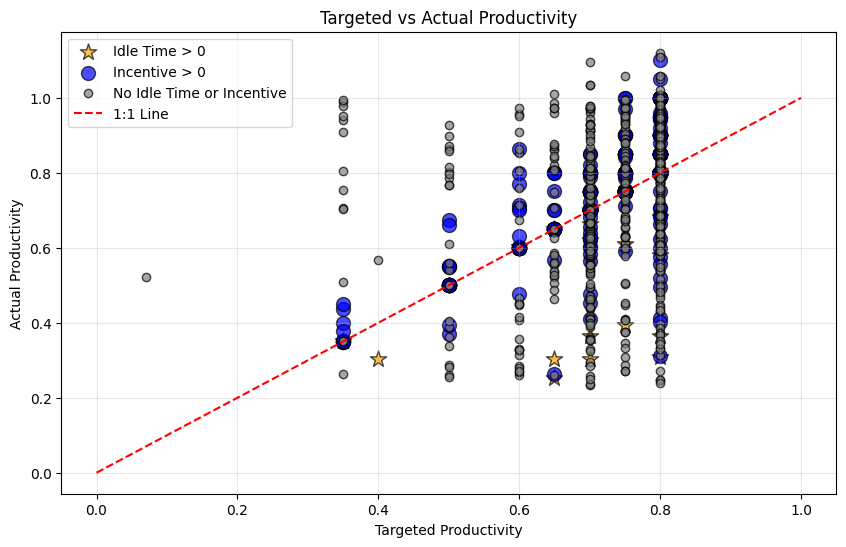

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Create scatter plot for points with idle time > 0 (stars)
scatter_idle_time = plt.scatter(
    df[df['idle_time'] > 0]['targeted_productivity'],
    df[df['idle_time'] > 0]['actual_productivity'],
    marker='*', c='orange', label='Idle Time > 0', alpha=0.7, edgecolor='k', s=150
)

# Create scatter plot for points with incentive > 0 (colored differently)
scatter_incentive = plt.scatter(
    df[df['incentive'] > 0]['targeted_productivity'],
    df[df['incentive'] > 0]['actual_productivity'],
    marker='o', c='blue', label='Incentive > 0', alpha=0.7, edgecolor='k', s=100
)

# Create scatter plot for points with neither condition (default appearance)
scatter_default = plt.scatter(
    df[(df['idle_time'] == 0) & (df['incentive'] == 0)]['targeted_productivity'],
    df[(df['idle_time'] == 0) & (df['incentive'] == 0)]['actual_productivity'],
    marker='o', c='gray', label='No Idle Time or Incentive', alpha=0.7, edgecolor='k'
)

# Add a 1:1 line for targeted vs actual productivity
plt.plot([0, 1], [0, 1], 'r--', label='1:1 Line')

plt.title("Targeted vs Actual Productivity")
plt.xlabel("Targeted Productivity")
plt.ylabel("Actual Productivity")
plt.legend()
plt.grid(alpha=0.3)
plt.show()